In [1]:
import os
os.chdir("/n/fs/nlp-df22/project/diversity/clean")

In [2]:
import importlib
import random

import datasets
from matplotlib import pyplot as plt
import numpy as np
import scipy.sparse
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import torch
from torch import nn
from torchvision.models import inception_v3
import torchvision

from transformers import AutoModel, AutoTokenizer

In [3]:
from vendi_score import vendi, data_utils, text_utils

### Load data

Load the MultiNLI dataset. Each example is stored in a utility class called `data_utils.Example` to keep track of features and metadata. The string is stored in `example.x`.

In [4]:
mnli_examples = text_utils.get_mnli()
print(len(mnli_examples))

Using custom data configuration default
Reusing dataset multi_nli (/n/fs/nlp-df22/.cache/hf/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)
Using custom data configuration default
Reusing dataset multi_nli (/n/fs/nlp-df22/.cache/hf/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)


6669


In [5]:
e = mnli_examples[1]
print("Sentence:", e.x)
print("Genre:", e.labels["y"])

Sentence: This site includes a list of all award winners and a searchable database of Government Executive articles.
Genre: government


### Which MultiNLI categories are most diverse?

We'll see which MultiNLI genres get the highest and lowest diversity scores using three different similarity scores: an n-gram overlap score, and the cosine similarity between neural network embeddings.

In [6]:
categories = sorted(set(e.labels["y"] for e in mnli_examples))
category_groups = {c: data_utils.Group(c, []) for c in categories}
for e in mnli_examples:
    category_groups[e.labels["y"]].examples.append(e)
groups = list(category_groups.values())
for g in groups:
    print(g.name, len(g.examples))

facetoface 667
fiction 666
government 667
letters 667
nineeleven 667
oup 667
slate 667
telephone 667
travel 667
verbatim 667


In [7]:
tokenizer = text_utils.get_tokenizer()

In [8]:
for group in groups:
    sents = [e.x for e in group.examples]
    for n in (1, 2, 3, 4):
        X = text_utils.get_ngrams(sents, n=n, tokenizer=tokenizer)
        group.features[f"{n}-grams"] = X = normalize(X, axis=1)
        group.Ks[f"{n}-grams"] = K = (X @ X.T).toarray()
        group.metrics[f"{n}-grams/VS"] = vendi.score_K(K)
    group.Ks[f"N-grams"] = K = np.stack([group.Ks[f"{n}-grams"] for n in (1, 2, 3, 4)], 0).mean(0)
    group.metrics[f"N-grams/VS"] = vendi.score_K(K)

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

models = [("Unsupervised SimCSE", "princeton-nlp/unsup-simcse-roberta-base"),
          ("Supervised SimCSE", "princeton-nlp/sup-simcse-roberta-base")]

for name, path in models:
    tok = AutoTokenizer.from_pretrained(path, use_fast=True)
    model = AutoModel.from_pretrained(path).eval().to(device)
    for group in groups:
        group.features[name] = X = text_utils.get_embeddings(
            [e.x for e in group.examples], model=model, tokenizer=tok
        )
        group.metrics[f"{name}/vNd"] = vendi.score_X(X)

In [9]:
from vendi_score import notebook_utils

rows = []
keys = sorted(groups[0].metrics.keys())
for group in groups:
    row = [f"group.name"] + [f"{group.metrics[k]:.02f}" for k in keys]
    rows.append(row)
notebook_utils.markdown_table(["Genre"] + keys, rows)

Genre|1-grams/VS|2-grams/VS|3-grams/VS|4-grams/VS|N-grams/VS
:---|:---:|:---:|:---:|:---:|---:
**group.name**|81.63|450.16|640.18|660.79|444.22
**group.name**|124.92|486.68|646.09|662.97|480.25
**group.name**|145.90|567.07|662.44|659.10|509.44
**group.name**|132.63|526.48|650.47|658.66|492.76
**group.name**|115.31|503.75|646.33|660.02|473.13
**group.name**|130.41|570.27|662.80|666.05|503.95
**group.name**|156.99|559.31|665.21|666.81|515.68
**group.name**|102.41|542.52|646.15|661.59|491.45
**group.name**|127.80|559.69|664.05|666.34|495.21
**group.name**|131.80|574.74|661.15|666.06|506.97

In [10]:
rows = []
keys = sorted(groups[0].metrics.keys())
ranks = {}
for key in keys:
    order = list(np.argsort(-np.array([g.metrics[key] for g in groups])))
    ranks[key] = [order.index(i) for i in range(len(order))]
for i, group in enumerate(groups):
    row = [group.name] + [f"{ranks[k][i]}" for k in keys]
    rows.append(row)
notebook_utils.markdown_table(["Genre"] + keys, rows)

Genre|1-grams/VS|2-grams/VS|3-grams/VS|4-grams/VS|N-grams/VS
:---|:---:|:---:|:---:|:---:|---:
**facetoface**|9|9|9|6|9
**fiction**|6|8|8|4|7
**government**|1|2|3|8|1
**letters**|2|6|5|9|5
**nineeleven**|7|7|6|7|8
**oup**|4|1|2|3|3
**slate**|0|4|0|0|0
**telephone**|8|5|7|5|6
**travel**|5|3|1|1|4
**verbatim**|3|0|4|2|2

### Detecting mode dropping

We'll create a mode dropping scenario by sampling 10 datasets, $S_1, \ldots, S_{10}$, each $S_i$ containing 500 sentences selected uniformly from the first $i$ categories. The Vendi score is compared to IntDiv: $\mathrm{IntDiv}(K) = 1 - \frac{1}{n^2}\sum_{i, j}K_{ij}$ for an $n \times n$ similarity matrix $K$.

In [11]:
tokenizer = text_utils.get_tokenizer()

In [12]:
random.seed(0)
cats = sorted(categories)
label_to_examples = {group.name: group.examples for group in category_groups.values()}
mode_dropping_groups = data_utils.mode_dropping_groups(label_to_examples, cats, N=500)

In [13]:
for group in mode_dropping_groups:
    sents = [e.x for e in group.examples]
    for n in (1, 2, 3, 4):
        X = text_utils.get_ngrams(sents, n=n, tokenizer=tokenizer, binary=True)
        group.features[f"{n}-grams"] = X = normalize(X, axis=1)
        group.Ks[f"{n}-grams"] = K = (X @ X.T).toarray()
        group.metrics[f"{n}-grams/VS"] = vendi.score_K(K)
        group.metrics[f"{n}-grams/IntDiv"] = vendi.intdiv_K(K)
    group.Ks[f"N-grams"] = K = np.stack([group.Ks[f"{n}-grams"] for n in (1, 2, 3, 4)], 0).mean(0)
    group.metrics[f"N-grams/VS"] = vendi.score_K(K)
    group.metrics[f"N-grams/IntDiv"] = vendi.intdiv_K(K)

In [14]:
for group in mode_dropping_groups:
    sents = [e.x for e in group.examples]
    group.metrics["N-gram diversity"] = text_utils.ngram_diversity(sents, tokenizer=tokenizer)

In [16]:
# for group in mode_dropping_groups:
#     group.metrics["Self BLEU"] = text_utils.self_bleu([e.x for e in group.examples], tokenizer)

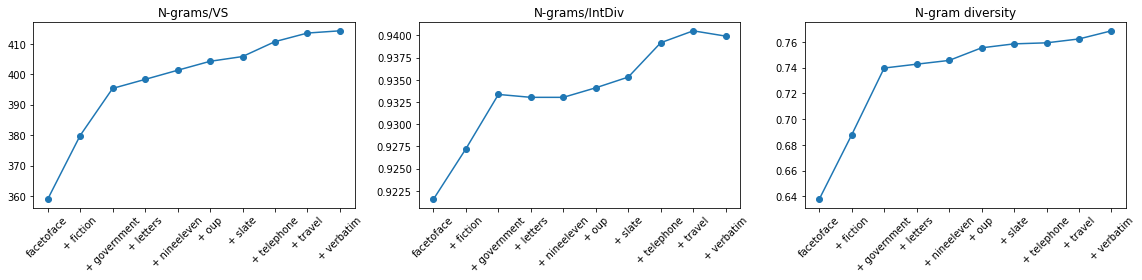

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, metric in zip(axes, ("N-grams/VS", "N-grams/IntDiv", "N-gram diversity")):#, "Self BLEU")):
    ax.set_title(metric)
    ax.plot([g.name for g in mode_dropping_groups],
            [g.metrics[metric] for g in mode_dropping_groups],
            marker="o")
    xticks = [cats[0]] + [f"+ {c}" for c in cats[1:]]
    ax.set_xticks([g.name for g in mode_dropping_groups])
    ax.set_xticklabels(xticks, rotation=45)
    
plt.tight_layout()    
plt.show()

In [18]:
SMALL_SIZE = 5
MEDIUM_SIZE = 7
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=False)

In [19]:
cmap = plt.cm.get_cmap("Set1")
colors = cmap.colors

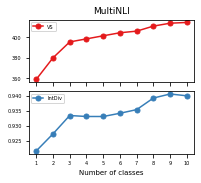

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(2.75, 2.5), sharex=True)
for i, (ax, metric) in enumerate(zip(axes, ("VS", "IntDiv"))):
    #ax.set_title(metric)
    for feature in ("N-grams",):
        ax.plot([g.name for g in mode_dropping_groups],
                [g.metrics[f"{feature}/{metric}"] for g in mode_dropping_groups],
                marker="o", color=colors[i], label=metric, markersize=5)
                #label=feature.title())
    xticks = [cats[0]] + [f"+ {c}" for c in cats[1:]]
    ax.set_xticks([g.name for g in mode_dropping_groups])
    #ax.set_xticklabels(xticks, rotation=45, horizontalalignment="right", fontsize=7)
    ax.set_xticklabels([g.name for g in mode_dropping_groups])
    ax.legend()
axes[1].set_xlabel("Number of classes")    
axes[0].set_title("MultiNLI", size=9)
plt.tight_layout()
#fig.subplots_adjust(top=0.9)
plt.savefig("mnli_modes.pdf", dpi=300)
plt.show()

In [75]:
feature = "N-grams"
for metric in ("vNd", "IntDiv"):
    x = [g.name for g in mode_dropping_groups]
    y = [g.metrics[f"{feature}/{metric}"] for g in mode_dropping_groups]
    print(metric, spearmanr(x, y))

vNd SpearmanrResult(correlation=0.9999999999999999, pvalue=6.646897422032013e-64)
IntDiv SpearmanrResult(correlation=0.9393939393939393, pvalue=5.484052998513666e-05)


In [77]:
feature = "N-grams"
for metric in ("vNd", "IntDiv"):
    x = [g.name for g in mode_dropping_groups]
    y = [g.metrics[f"{feature}/{metric}"] for g in mode_dropping_groups]
    print(metric, pearsonr(x, y))

vNd (0.8956426378289939, 0.0004566882392696715)
IntDiv (0.9258867307280253, 0.00012061581342668988)
